In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Module Setting
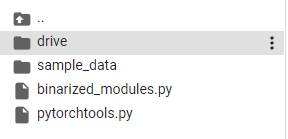
pytorchtools, binarized_modules import필요 
다른 방법으로 해도 무방

In [1]:
import torch
import torchvision
import torchvision.transforms as tr
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pytorchtools import EarlyStopping
from pytorchtools import EarlyStopping_acc
from torchsummary import summary as summary_

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Function
from binarized_modules import  BinarizeLinear,BinarizeConv2d
from torch.autograd import Variable

In [2]:
def preprocessing(person,motion): # person, motion에 해당하는 image 불러옴
    date = '220132'
#    file_name = '_cwt.txt'
    file_name = '_stft.txt'
    DirectoryPath = '/content/drive/MyDrive/data/class12/'
    whole_count = 100
#    image = np.zeros(shape=(whole_count, 81, 1920, 1))
    image = np.zeros(shape=(whole_count, 128, 29, 1))
    label = []
    cwt_data = pd.read_csv(
                DirectoryPath + date + "_" + str(person) + "_" + str(motion) + file_name)
    for i in range(0, whole_count):
        df = np.fromstring(cwt_data['pixels'][i], dtype=int, sep=' ')
#        df = np.reshape(df, (81, 1920, 1))
        df = np.reshape(df, (128, 29, 1))
        image[i] = df
        label.append(person-1)    # 사람으로 구분
    return image, label



# 시작과 끝 좌표는 scale한 후의 좌표를 기준으로 함
def preprocessing_resize_crop(image,start_row,end_row,start_col,end_col,row_scale,col_scale): 
    crop_image = image[:,0:image.shape[1]:row_scale,0:image.shape[2]:col_scale]
    crop_image = crop_image[:,start_row:end_row,start_col:end_col]
    return crop_image

def concatenate_n_div(image0, label0, image1, label1, image2, label2, image3, label3): # ratio비율로 각 data set을 합치고 순서도 섞음
    

    count = 100
    train_ratio = 0.7
    val_ratio = 0.15
    test_ratio = 0.15 # 적용안됨
    
    x_train = np.concatenate((image0[0:int(count*train_ratio)], image1[0:int(count*train_ratio)], image2[0:int(count*train_ratio)],
                              image3[0:int(count*train_ratio)]))
    y_train = np.concatenate((label0[0:int(count*train_ratio)], label1[0:int(count*train_ratio)], label2[0:int(count*train_ratio)],
                              label3[0:int(count*train_ratio)]))
    x_val = np.concatenate((image0[int(count*train_ratio) : int(count*train_ratio + count*val_ratio)],
                            image1[int(count*train_ratio) : int(count*train_ratio + count*val_ratio)],
                            image2[int(count*train_ratio) : int(count*train_ratio + count*val_ratio)],
                            image3[int(count*train_ratio) : int(count*train_ratio + count*val_ratio)]))
    y_val = np.concatenate((label0[int(count*train_ratio) : int(count*train_ratio + count*val_ratio)],
                            label1[int(count*train_ratio) : int(count*train_ratio + count*val_ratio)],
                            label2[int(count*train_ratio) : int(count*train_ratio + count*val_ratio)],
                            label3[int(count*train_ratio) : int(count*train_ratio + count*val_ratio)]))
    x_test = np.concatenate((image0[int(count*train_ratio + count*val_ratio) : count],
                             image1[int(count*train_ratio + count*val_ratio) : count],
                             image2[int(count*train_ratio + count*val_ratio) : count],
                             image3[int(count*train_ratio + count*val_ratio) : count]))
    y_test = np.concatenate((label0[int(count*train_ratio + count*val_ratio) : count],
                             label1[int(count*train_ratio + count*val_ratio) : count],
                             label2[int(count*train_ratio + count*val_ratio) : count],
                             label3[int(count*train_ratio + count*val_ratio) : count]))
    
    s = np.arange(x_train.shape[0])
    np.random.shuffle(s)
    x_train = x_train[s]
    y_train = y_train[s]

    s = np.arange(x_val.shape[0])
    np.random.shuffle(s)
    x_val = x_val[s]
    y_val = y_val[s]

    s = np.arange(x_test.shape[0])
    np.random.shuffle(s)
    x_test = x_test[s]
    y_test = y_test[s]
    return x_train, y_train, x_val, y_val, x_test, y_test

class TensorData(Dataset):
    
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.x_data = self.x_data.permute(0,3,1,2) # 이미지 개수, 채널 수, 이미지 너비, 높이
        self.y_data = torch.LongTensor(y_data)
        self.len = self.y_data.shape[0]
        
    def __getitem__(self, index):
        
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

In [8]:
# SCALE:16 /1초 추출 + 0.2초 씩 이동 / row 30
#=========================================================
#================파라미터 설정==========================
#============================================================
# STFT = (128, 29) //  CWT = (81,1920)
# 좌표는 스케일 이후 범위
start_row = 46
end_row = 82
scale_row = 1
rows = 128

start_col = 0
end_col = 28
scale_col = 1
cols = 29

aug = 1  # 1이면 augmentation 0이면 X

gen = ImageDataGenerator(
                         width_shift_range=0.2
                            )


motion = 3  # 추출 모션

image1,label1 = preprocessing(1,motion) # 성진_motion 불러옴
image2,label2 = preprocessing(2,motion) # 호정_motion 불러옴
image3,label3 = preprocessing(3,motion) # 경민_motion 불러옴
image4,label4 = preprocessing(4,motion) # 경민_motion 불러옴

# 정규화 추가
total_img = np.concatenate((image1, image2, image3, image4))
total_std = total_img.std()
total_mean = total_img.mean()



In [9]:
class Net(nn.Module):

    def __init__(self, num_classes=4):
        super(Net,self).__init__()
        self.infl_ratio=3;
        self.features = nn.Sequential(
            # BinarizeConv2d(입력 채널수, 출력 채널수, 커널 사이즈, 스트라이드, 패딩)
            BinarizeConv2d(1, 16*self.infl_ratio,kernel_size=3,stride=1,padding=0),
            nn.MaxPool2d(kernel_size=3, stride=1),
            # nn.BatchNorm2d(입출력 채널수)
            nn.BatchNorm2d(16*self.infl_ratio),
            nn.Hardtanh(),

            BinarizeConv2d(16*self.infl_ratio, 16*self.infl_ratio,kernel_size=3,stride=1,padding=0),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.BatchNorm2d(16*self.infl_ratio),
            nn.Hardtanh(),

            BinarizeConv2d(16*self.infl_ratio, 16*self.infl_ratio,kernel_size=3,stride=1,padding=0),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.BatchNorm2d(16*self.infl_ratio),
            nn.Hardtanh(),

            BinarizeConv2d(16*self.infl_ratio, 16,kernel_size=3,stride=1,padding=0),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.BatchNorm2d(16),
            nn.Hardtanh()

         )
            
        self.classifier = nn.Sequential(
            # BinarizeLinear(입력 dense길이, 출력 dense길이)
            BinarizeLinear(16*20*12,num_classes)
            
        )
        self.softmax = nn.Softmax()
                
                
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1,16*20*12)
        x = self.classifier(x)
        return self.softmax(x)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [11]:
net = Net().to(device)
print(net)

Net(
  (features): Sequential(
    (0): BinarizeConv2d(1, 48, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Hardtanh(min_val=-1.0, max_val=1.0)
    (4): BinarizeConv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Hardtanh(min_val=-1.0, max_val=1.0)
    (8): BinarizeConv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
    (9): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Hardtanh(min_val=-1.0, max_val=1.0)
    (12): BinarizeConv2d(48, 16, kernel_size=(3, 3), stride=(1, 1))
    (13): MaxPool2d(kernel_size=3, stride=1, 

In [12]:
summary_(net,(1,36,28),batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    BinarizeConv2d-1           [32, 48, 34, 26]             480
         MaxPool2d-2           [32, 48, 32, 24]               0
       BatchNorm2d-3           [32, 48, 32, 24]              96
          Hardtanh-4           [32, 48, 32, 24]               0
    BinarizeConv2d-5           [32, 48, 30, 22]          20,784
         MaxPool2d-6           [32, 48, 28, 20]               0
       BatchNorm2d-7           [32, 48, 28, 20]              96
          Hardtanh-8           [32, 48, 28, 20]               0
    BinarizeConv2d-9           [32, 48, 26, 18]          20,784
        MaxPool2d-10           [32, 48, 24, 16]               0
      BatchNorm2d-11           [32, 48, 24, 16]              96
         Hardtanh-12           [32, 48, 24, 16]               0
   BinarizeConv2d-13           [32, 16, 22, 14]           6,928
        MaxPool2d-14           [32, 16,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [22]:
args_cuda = not False and torch.cuda.is_available()
# epoch_num : 훈련 한번에 epoch을 몇번 실행하는지
def train_1(epoch_num):
    early_stopping = EarlyStopping_acc(patience = patience, verbose = True) # 다른 함수로 EarlyStopping는 loss기준
    arr_acc = []
    for epoch in range(1,epoch_num + 1):
        valid_losses = []
        train_losses = [] 
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            if args_cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            train_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            for p in list(model.parameters()):
                if hasattr(p,'org'):
                    p.data.copy_(p.org)
            optimizer.step()
            for p in list(model.parameters()):
                if hasattr(p,'org'):
                    p.org.copy_(p.data.clamp_(-1,1))

            # if batch_idx % 10 == 0:
            #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #         epoch, batch_idx * len(data), len(train_loader.dataset),
            #         100. * batch_idx / len(train_loader), loss.item()))

        # valid_data로 평가
        correct =0
        for batch_idx, (data, target) in enumerate(valid_loader):
            if args_cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            loss = criterion(output, target)
            valid_losses.append(loss.item())
            
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        val_acc = 100. * correct / len(valid_loader.dataset)

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)


        epoch_len = len(str(epoch_num))

        print(f"\n현재 epoch : {epoch}\n")
        print_msg = (f'[{epoch:>{epoch_len}}/{epoch_num:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'valid_accuary: {val_acc:.1f}%')

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping는 validation acc가 감소하였는지 확인이 필요하며,
        # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
        

        # earlystopping 
        early_stopping(val_acc, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        if epoch%10==0:
            optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.9  # 훈련이 진행됨에 따라 lr 감소
        eval()
    #model.load_state_dict(torch.load('checkpoint.pt')) # earlystopping이 끝나고 best모델을 load할지
    test() # test data의 결과 추이도 보기 위해 추가함

# test와 eavl 차이는 마지막에 정확도를 list에 추가하는지 여부만 다름

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if args_cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    arr_acc.append((100. * correct / len(test_loader.dataset)).item())

def eval():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if args_cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [23]:
try_num = 20 # 전체 시도 회수
arr_acc = []
patience = 10  # earlystopping patience
for n in range(1,try_num+1):
    s = np.arange(image1.shape[0])
    np.random.shuffle(s)
    image1_shuff = image1[s]       # 불러온 성진_motion data의 순서를 섞음

    s = np.arange(image2.shape[0])
    np.random.shuffle(s)
    image2_shuff = image2[s]       # 불러온 호정_motion data의 순서를 섞음

    s = np.arange(image3.shape[0])
    np.random.shuffle(s)
    image3_shuff = image3[s]       # 불러온 3_motion data의 순서를 섞음

    s = np.arange(image4.shape[0])
    np.random.shuffle(s)
    image4_shuff = image4[s]       # 불러온 4_motion data의 순서를 섞음

    image1_crop = preprocessing_resize_crop(
        image1_shuff, start_row, end_row, start_col, end_col, scale_row, scale_col)
    image2_crop = preprocessing_resize_crop(
        image2_shuff, start_row, end_row, start_col, end_col, scale_row, scale_col)
    image3_crop = preprocessing_resize_crop(
        image3_shuff, start_row, end_row, start_col, end_col, scale_row, scale_col)
    image4_crop = preprocessing_resize_crop(
        image4_shuff, start_row, end_row, start_col, end_col, scale_row, scale_col)

    x_train, y_train, x_val, y_val, x_test, y_test = concatenate_n_div(
            image1_crop, label1, image2_crop, label2, image3_crop, label3, image4_crop, label4)
                # 자른 image를 각 data set으로 나눠서 합침

    #===========잠시 ==========
    # maxval = x_train.max()
    # if maxval < x_val.max():
    #     maxval = x_val.max()
    # if maxval < x_test.max():
    #     maxval = x_test.max()
    # # 정규화
    # x_train = x_train.astype('float32')/maxval
    # x_val = x_val.astype('float32')/maxval
    # x_test = x_test.astype('float32')/maxval
    x_train = (x_train - total_mean) / total_std
    x_val = (x_val - total_mean) / total_std
    x_test = (x_test - total_mean) / total_std

    # 보강할 학습데이터 이미지 생성
    if aug == 1:
        augment_ratio = 9   # 전체 데이터의 150%
        augment_size = int(augment_ratio * x_train.shape[0])

        # 전체 x_train 개수의 150% 비율만큼
        randidx = np.random.randint(x_train.shape[0], size=augment_size)

        # 임의로 선택된 데이터는 원본데이터를 참조하기 때문에
        # 원본데이터에 영향을 줄수 있음. 그래서 copy() 함수를 통해 안전하게 복사본 만듬
        x_augmented = x_train[randidx].copy()  
        y_augmented = y_train[randidx].copy()

        #  이미지 보강 실행
        x_augmented, y_augmented = gen.flow(x_augmented, y_augmented, 
                                            batch_size=augment_size,
                                            shuffle=False).next()

        x_train = np.concatenate((x_train,x_augmented))
        y_train = np.concatenate((y_train,y_augmented))
        s = np.arange(x_train.shape[0])
        np.random.shuffle(s)
        x_train = x_train[s]
        y_train = y_train[s]

    train_data = TensorData(x_train,y_train)
    test_data = TensorData(x_test,y_test)
    valid_data = TensorData(x_val,y_val)
    train_loader = DataLoader(train_data, batch_size = 32, shuffle =True)
    test_loader = DataLoader(test_data, batch_size = 32, shuffle =True)
    valid_loader = DataLoader(valid_data, batch_size = 32, shuffle =True)

    model = Net()
    if args_cuda:
        torch.cuda.set_device(0)
        model.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    print(f"전체 시도 횟수 {n}")
    train_1(100)

print(f"\n {try_num}회 평균 정확도는 {sum(arr_acc)/try_num:.1f}%, 최댓값은 {max(arr_acc):.1f}%, 최솟값은 {min(arr_acc):.1f}%")
    

전체 시도 횟수 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



현재 epoch : 1

[  1/100] train_loss: 1.38493 valid_loss: 1.25311 valid_accuary: 48.3%
Validation accuray increased (inf --> 48.333332).  Saving model ...

Test set: Average loss: 0.0425, Accuracy: 28/60 (47%)


현재 epoch : 2

[  2/100] train_loss: 1.28875 valid_loss: 1.28016 valid_accuary: 46.7%
EarlyStopping counter: 1 out of 10

Test set: Average loss: 0.0435, Accuracy: 26/60 (43%)


현재 epoch : 3

[  3/100] train_loss: 1.28624 valid_loss: 1.23324 valid_accuary: 50.0%
Validation accuray increased (48.333332 --> 50.000000).  Saving model ...

Test set: Average loss: 0.0440, Accuracy: 26/60 (43%)


현재 epoch : 4

[  4/100] train_loss: 1.26550 valid_loss: 1.24094 valid_accuary: 50.0%
Validation accuray increased (50.000000 --> 50.000000).  Saving model ...

Test set: Average loss: 0.0402, Accuracy: 32/60 (53%)


현재 epoch : 5

[  5/100] train_loss: 1.26586 valid_loss: 1.20490 valid_accuary: 53.3%
Validation accuray increased (50.000000 --> 53.333332).  Saving model ...

Test set: Average lo

KeyboardInterrupt: ignored

In [ ]:
print(f"\n {try_num}회 평균 정확도는 {sum(arr_acc)/try_num:.1f}%, 최댓값은 {max(arr_acc):.1f}%, 최솟값은 {min(arr_acc):.1f}%")



 10회 평균 정확도는 72.3%, 최댓값은 85.0%, 최솟값은 60.0%
